In [334]:
import sys
sys.path.append('..')

In [335]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime
import re
from src.db import ProductTable, SellerTable, engine, SessionLocal

In [336]:
db_session = SessionLocal()

### Getting data from .parquet files

In [337]:
output_folder = '../src/parser/data8'

data = []
for file in os.listdir(output_folder):
    if file.endswith('.parquet'):
        df = pd.read_parquet(f'{output_folder}/{file}')
        data.append(df)
data = pd.concat(data)

In [338]:
print(data.shape)
data.head()

(2598, 23)


,title,price,characteristics,description,views,date,location,link,seller_id,today_views,about,is_sold,name,rating,reviews,subscribers,subscriptions,registered,done_deals,active_deals,docs_confirmed,phone_confirmed,response_time
0,"iPhone 16, 128 ГБ",81990,"{'IMEI': None, 'Встроенная память': '128 ГБ', ...","В наличии Аpрle iPhonе 16 128 GВ Ultrаmаrine, ...",3056,· 11 ноября 2024,"Санкт-Петербург, Кирочная ул., 5",https://www.avito.ru/sankt-peterburg/telefony/...,/brands/ibox,17,"{'Комплект': 'Коробка, Провод зарядки', 'Короб...",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"iPhone 16 Pro, 256 ГБ",123900,"{'IMEI': None, 'Встроенная память': '256 ГБ', ...",Нoвый. Зaпечaтанный. Оpигинал. Корoбка зaпечат...,9166,· 28 декабря 2024,"Санкт-Петербург, ул. Жуковского, 28",https://www.avito.ru/sankt-peterburg/telefony/...,/brands/i137588249,9,"{'Комплект': 'Коробка', 'Коробка запечатана': ...",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"iPhone 13, 128 ГБ",33090,"{'IMEI': None, 'Встроенная память': '128 ГБ', ...",✨Тradе-in от MIRАPHОNЕ на НOВЫX УСЛОBИЯХ! Не у...,865,· 13 декабря 2024,"Санкт-Петербург, Садовая ул., 38",https://www.avito.ru/sankt-peterburg/telefony/...,/brands/i59503469,26,"{'Комплект': None, 'Коробка запечатана': None,...",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"iPhone 13 Pro, 128 ГБ",35590,"{'IMEI': None, 'Встроенная память': '128 ГБ', ...",Hаш мaгaзин цифровой тeхникиТе:hubзанимaетcя п...,7320,· 10 декабря 2024,"Санкт-Петербург, пл. Стачек, 9",https://www.avito.ru/sankt-peterburg/telefony/...,/brands/244096b73b687e69b4c9374622919ee3,50,"{'Комплект': 'Коробка', 'Коробка запечатана': ...",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"iPhone 16 Pro Max, 256 ГБ",134990,"{'IMEI': None, 'Встроенная память': '256 ГБ', ...",НOBЫЙ✅ ЕBPОTЕСТ🇪🇺 ВCЕ ЦBЕTA✅ ТRADE-IN | ДОСTABKA✅,4892,· вчера в 14:17,"Санкт-Петербург, Банковский пер., 4",https://www.avito.ru/sankt-peterburg/telefony/...,/brands/i156460275,6,"{'Комплект': 'Коробка, Провод зарядки', 'Короб...",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Getting data from database using sqlAlchemy

In [339]:
products = db_session.query(ProductTable).all()
sellers = db_session.query(SellerTable).all()

In [340]:
import json

# products to dataframe
products_data = []
for product in products:
    products_data.append(product.__dict__)
products_data = pd.DataFrame(products_data)

# deserialize the characteristics and about from json
products_data['characteristics'] = products_data['characteristics'].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
products_data['about'] = products_data['about'].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
products_data.drop(columns=['_sa_instance_state'], inplace=True)

# sellers to dataframe
sellers_data = []
for seller in sellers:
    sellers_data.append(seller.__dict__)
sellers_data = pd.DataFrame(sellers_data)
sellers_data.drop(columns=['_sa_instance_state'], inplace=True)


In [341]:
products_data.head()

,title,characteristics,views,location,today_views,is_sold,price,link,description,date,seller_id,about
0,"iPhone 11, 128 ГБ","{'IMEI': None, 'Встроенная память': '128 ГБ', ...",647.0,"Санкт-Петербург, Торфяная дорога, 15к1",0.0,False,18500.0,https://www.avito.ru/sankt-peterburg/telefony/...,Без сколов и дефектов.Все детали в рабочем сос...,· 12 декабря 2024,14c4bda6-d5ac-40f8-9f27-98a61a192948,"{'Комплект': None, 'Коробка запечатана': None,..."
1,"iPhone 11, 128 ГБ","{'IMEI': None, 'Встроенная память': '128 ГБ', ...",268.0,"Санкт-Петербург, Штурманская ул., 30",4.0,False,18000.0,https://www.avito.ru/sankt-peterburg/telefony/...,Использовался с защитным стеклом. Чехол в пода...,· 16 декабря 2024,fe188415-7ad5-4a3c-91d9-007b043c9ecc,"{'Комплект': None, 'Коробка запечатана': None,..."
2,"iPhone Xr, 128 ГБ","{'IMEI': None, 'Встроенная память': '128 ГБ', ...",429.0,Санкт-Петербург,8.0,False,12000.0,https://www.avito.ru/sankt-peterburg/telefony/...,айфон xr,· 4 декабря 2024,5677aa18-c4db-4be3-9bc5-2b64837c0e54,"{'Комплект': None, 'Коробка запечатана': None,..."
3,"iPhone 11, 256 ГБ","{'IMEI': None, 'Встроенная память': '256 ГБ', ...",373.0,Санкт-Петербург,12.0,False,15225.0,https://www.avito.ru/sankt-peterburg/telefony/...,Прoдaм iРhone 11 256gb жeлтoго цвета (yеllow),· 30 декабря 2024,/brands/e6a07ae9210c18e0b9a6cf2512c3f5cb,"{'Комплект': 'Блок зарядки, Провод зарядки', '..."
4,"iPhone 11, 128 ГБ",None,NaN,"Санкт-Петербург, пр-т Славы, 9",NaN,True,14500.0,/sankt-peterburg/telefony/iphone_11_128_gb_484...,None,23 декабря 2024,/brands/e6a07ae9210c18e0b9a6cf2512c3f5cb,None


In [372]:
df.describe()

,views,today_views,price,date,version,capacity,rating,subscribers,registered,active_deals,reviews,subscriptions,done_deals,price_coeff
count,614.000000,614.000000,1457.000000,1503,1461.000000,1465.000000,1369.000000,1122.000000,1147,1147.000000,1136.000000,1122.000000,1147.000000,598.000000
mean,3791.905537,15.024430,41809.236102,2024-09-26 07:23:22.674650368,12.062971,172.544710,4.812929,2321.461676,2019-05-22 08:05:51.525719040,105.322581,424.147887,22.806595,761.690497,0.848563
min,5.000000,0.000000,10.000000,2013-05-01 00:00:00,4.000000,1.000000,1.000000,0.000000,2010-11-01 00:00:00,1.000000,1.000000,0.000000,0.000000,0.000714
25%,134.750000,3.000000,12500.000000,2024-11-01 00:00:00,10.000000,64.000000,4.800000,47.000000,2016-09-01 00:00:00,7.000000,46.000000,1.000000,51.000000,0.764706
50%,404.500000,7.000000,23990.000000,2024-12-01 00:00:00,12.000000,128.000000,4.900000,628.000000,2020-06-01 00:00:00,30.000000,212.000000,6.000000,166.000000,0.899609
75%,1974.000000,17.750000,59990.000000,2024-12-16 00:00:00,14.000000,256.000000,5.000000,2823.000000,2022-08-01 00:00:00,144.000000,550.000000,23.000000,839.000000,1.000000
max,282691.000000,231.000000,211000.000000,2024-12-31 00:00:00,16.000000,1024.000000,5.000000,24252.000000,2024-12-18 00:00:00,2521.000000,2636.000000,500.000000,9999.000000,1.000000
std,15227.940986,22.739343,40208.402167,NaN,2.622637,141.213804,0.465319,3463.478920,NaN,192.555848,512.150111,57.242002,1416.748916,0.175405


### Cleaning data

In [343]:
month_map = {
    'января': 'January',
    'февраля': 'February',
    'марта': 'March',
    'апреля': 'April',
    'мая': 'May',
    'июня': 'June',
    'июля': 'July',
    'августа': 'August',
    'сентября': 'September',
    'октября': 'October',
    'ноября': 'November',
    'декабря': 'December'
}

def parse_timestamp(timestamp):
    cleaned = timestamp[2:].strip()

    for ru_month, en_month in month_map.items():
        if ru_month in cleaned:
            cleaned = cleaned.replace(ru_month, en_month)
            break
    if 'сегодня' in cleaned:
        cleaned = cleaned.replace('сегодня', datetime.now().strftime('%d %B'))
    elif 'вчера' in cleaned:
        cleaned = cleaned.replace('вчера', (datetime.now() - pd.Timedelta(days=1)).strftime('%d %B'))
    
    # check if year is not present (like 20...)
    if not cleaned[-4:].isdigit():
        # if day and month is 01-01 year is now
        if '01 January' in cleaned or '02 January' in cleaned:
            cleaned = cleaned + f' {datetime.now().year}'
        else:
            cleaned = cleaned + f' {datetime.now().year - 1}'
    try:
        return datetime.strptime(cleaned, '%d %B в %H:%M %Y')
    except ValueError:
        try:
            return datetime.strptime(cleaned, '%d %B %Y')
        except ValueError:
            return datetime.strptime(cleaned, '%B %Y')



In [344]:
# · 13 декабря в 23:09 to datetime
products_data['date'] = products_data['date'].apply(parse_timestamp)
products_data['date'].head()

0   2024-12-12
1   2024-12-16
2   2024-12-04
3   2024-12-30
4   2024-12-01
Name: date, dtype: datetime64[ns]

#### Getting new features from characteristics of the data
as :
- capacity
- phone version
- max version
- pro version

In [345]:
def parse_characteristics(characteristics):
    if not characteristics:
        return None, None, None, None
    version = None
    is_pro = False
    is_max = False
    capacity = None

    version_match = re.search(r'\biphone ?(\d+)', characteristics['Модель'], re.IGNORECASE)
    if version_match:
        version = int(version_match.group(1))
    
    xr_match = re.search(r'\b\w+ ?[Xx][rR]?', characteristics['Модель'])
    if xr_match and not version:
        version = 10
    if version is None:
        print(f'Version in {characteristics["Модель"]} not found')

    is_pro_match = re.search(r'[pP]ro', characteristics['Модель'])
    if is_pro_match:
        is_pro = True

    is_max_match = re.search(r'Max', characteristics['Модель'])
    if is_max_match:
        is_max = True

    capacity_match = re.search(r'(\d+) ?[gGtTгГтТ][bBбБ]', characteristics['Встроенная память'])
    if capacity_match:
        capacity = int(capacity_match.group(1))


    return version, is_pro, is_max, capacity    


In [346]:
def parse_title(title):
    if not title:
        return None, None, None, None
    version = None
    is_pro = False
    is_max = False
    capacity = None

    version_match = re.search(r'\biphone ?(\d+)', title, re.IGNORECASE)
    if version_match:
        version = int(version_match.group(1))

    xr_match = re.search(r'\b\w+ ?[Xx][rR]?', title)
    if xr_match and not version:
        version = 10
    if version is None:
        print(f'Version in {title} not found')

    if "pro" in title.lower():
        is_pro = True

    if "max" in title.lower():
        is_max = True

    capacity_match = re.search(r'(\d+) ?[gGtTгГтТ][bBбБ]', title)


    if capacity_match:
        capacity = int(capacity_match.group(1))

    return version, is_pro, is_max, capacity   

In [347]:
products_data['version'], products_data['is_pro'], products_data['is_max'], products_data['capacity'] = zip(*products_data.apply(lambda x: parse_title(x['title']) if x['is_sold'] else parse_characteristics(x['characteristics']), axis=1))   

Version in iPhone SE (2020), 64 ГБ not found
Version in iPhone SE (2020), 128 ГБ not found
Version in iPhone SE, 32 ГБ not found
Version in iPhone SE 2020 64gb sim+esim Оригинал Все Функции not found
Version in iPhone SE (2020) not found
Version in iPhone SE (2020) not found
Version in iPhone SE (2020), 128 ГБ not found
Version in iPhone SE, 128 ГБ not found
Version in iPhone SE (2020), 64 ГБ not found
Version in iPhone SE (2020) not found
Version in iPhone SE (2020) not found
Version in iPhone SE (2020) not found
Version in iPhone SE not found
Version in iPhone SE (2022) not found
Version in iPhone SE (2020) not found
Version in iPhone SE (2020), 64 ГБ not found
Version in iPhone SE, 32 ГБ not found
Version in iPhone SE (2020) not found
Version in iPhone SE 2020 SIM+eSIM not found
Version in iPhone SE (2020), 128 ГБ not found
Version in iPhone SE (2020) not found
Version in iPhone SE 2020 128gb SIM+eSIM not found
Version in iPhone SE 2020 SIM+eSIM not found
Version in iPhone SE (2020)

на некоторые проданные товары на сайте выдается слишком низкая цена

In [348]:
products_data['price'] = products_data.apply(lambda x: None if x['is_sold'] and x['price'] < 1000 else x['price'], axis=1)

In [349]:
# getting condition
products_data['condition'] = products_data['characteristics'].apply(lambda x: x['Состояние'] if x else None)

In [350]:
sellers_data.head()

,rating,seller_id,subscribers,registered,active_deals,phone_confirmed,name,reviews,subscriptions,done_deals,docs_confirmed,response_time
0,NaN,7aeef58e-c3f8-423a-a3c2-bb000756f1c7,NaN,None,NaN,False,Unknown,NaN,NaN,NaN,False,Отвечает около 30 минут
1,4.8,7777ebc4-ca00-4b4f-952f-203b549bae97,NaN,None,NaN,False,Unknown,NaN,NaN,NaN,True,None
2,4.8,84c47f4c-7ca5-4946-9e3e-609bb669a1f1,NaN,None,NaN,False,Unknown,NaN,NaN,NaN,False,Отвечает около 30 минут
3,NaN,8021f8e1-722a-4509-9c43-05434ae9d109,NaN,None,NaN,False,Unknown,NaN,NaN,NaN,False,Отвечает около часа
4,5.0,135b9f8c-70fb-449a-8df5-81703789ac72,NaN,None,NaN,False,Unknown,NaN,NaN,NaN,False,None


In [351]:
# На Авито с февраля 2011 to datetime
def parse_registered(timestamp):
    if timestamp is None:
        return None
    cleaned = timestamp.replace('На Авито с ', '').strip()

    for ru_month, en_month in month_map.items():
        if ru_month in cleaned:
            cleaned = cleaned.replace(ru_month, en_month)
            break

    try:
        return datetime.strptime(cleaned, '%d %B %Y')
    except ValueError:
        return datetime.strptime(cleaned, '%B %Y')
        

sellers_data['registered'] = sellers_data['registered'].apply(parse_registered)

In [352]:
# get the number of sellers registered with known date of registration
sellers_data['registered'].apply(lambda x: x if x.day != 1 else None).value_counts().head()

registered
2024-10-21    1
2024-11-09    1
2024-12-18    1
2024-11-06    1
2024-12-12    1
Name: count, dtype: int64

-------

In [353]:
# merge the data
df = products_data
df = df.merge(sellers_data, on='seller_id')

In [354]:
df.head()

,title,characteristics,views,location,today_views,is_sold,price,link,description,date,seller_id,about,version,is_pro,is_max,capacity,condition,rating,subscribers,registered,active_deals,phone_confirmed,name,reviews,subscriptions,done_deals,docs_confirmed,response_time
0,"iPhone 11, 128 ГБ","{'IMEI': None, 'Встроенная память': '128 ГБ', ...",647.0,"Санкт-Петербург, Торфяная дорога, 15к1",0.0,False,18500.0,https://www.avito.ru/sankt-peterburg/telefony/...,Без сколов и дефектов.Все детали в рабочем сос...,2024-12-12,14c4bda6-d5ac-40f8-9f27-98a61a192948,"{'Комплект': None, 'Коробка запечатана': None,...",11.0,False,False,128.0,Отличное,4.8,NaN,NaT,NaN,False,Unknown,NaN,NaN,NaN,True,None
1,"iPhone 11, 128 ГБ","{'IMEI': None, 'Встроенная память': '128 ГБ', ...",268.0,"Санкт-Петербург, Штурманская ул., 30",4.0,False,18000.0,https://www.avito.ru/sankt-peterburg/telefony/...,Использовался с защитным стеклом. Чехол в пода...,2024-12-16,fe188415-7ad5-4a3c-91d9-007b043c9ecc,"{'Комплект': None, 'Коробка запечатана': None,...",11.0,False,False,128.0,Удовлетворительное,NaN,NaN,NaT,NaN,False,Unknown,NaN,NaN,NaN,False,Отвечает около часа
2,"iPhone Xr, 128 ГБ","{'IMEI': None, 'Встроенная память': '128 ГБ', ...",429.0,Санкт-Петербург,8.0,False,12000.0,https://www.avito.ru/sankt-peterburg/telefony/...,айфон xr,2024-12-04,5677aa18-c4db-4be3-9bc5-2b64837c0e54,"{'Комплект': None, 'Коробка запечатана': None,...",10.0,False,False,128.0,Хорошее,5.0,NaN,NaT,NaN,False,Unknown,NaN,NaN,NaN,False,Отвечает за несколько часов
3,"iPhone 11, 256 ГБ","{'IMEI': None, 'Встроенная память': '256 ГБ', ...",373.0,Санкт-Петербург,12.0,False,15225.0,https://www.avito.ru/sankt-peterburg/telefony/...,Прoдaм iРhone 11 256gb жeлтoго цвета (yеllow),2024-12-30,/brands/e6a07ae9210c18e0b9a6cf2512c3f5cb,"{'Комплект': 'Блок зарядки, Провод зарядки', '...",11.0,False,False,256.0,Хорошее,4.8,11.0,2024-05-01,1.0,True,Okay let's go,18.0,3.0,56.0,True,Отвечает около 30 минут
4,"iPhone 11, 128 ГБ",None,NaN,"Санкт-Петербург, пр-т Славы, 9",NaN,True,14500.0,/sankt-peterburg/telefony/iphone_11_128_gb_484...,None,2024-12-01,/brands/e6a07ae9210c18e0b9a6cf2512c3f5cb,None,11.0,False,False,128.0,None,4.8,11.0,2024-05-01,1.0,True,Okay let's go,18.0,3.0,56.0,True,Отвечает около 30 минут


In [355]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   title            1503 non-null   object        
 1   characteristics  614 non-null    object        
 2   views            614 non-null    float64       
 3   location         1503 non-null   object        
 4   today_views      614 non-null    float64       
 5   is_sold          1503 non-null   bool          
 6   price            1457 non-null   float64       
 7   link             1503 non-null   object        
 8   description      614 non-null    object        
 9   date             1503 non-null   datetime64[ns]
 10  seller_id        1503 non-null   object        
 11  about            602 non-null    object        
 12  version          1461 non-null   float64       
 13  is_pro           1503 non-null   bool          
 14  is_max           1503 non-null   bool   

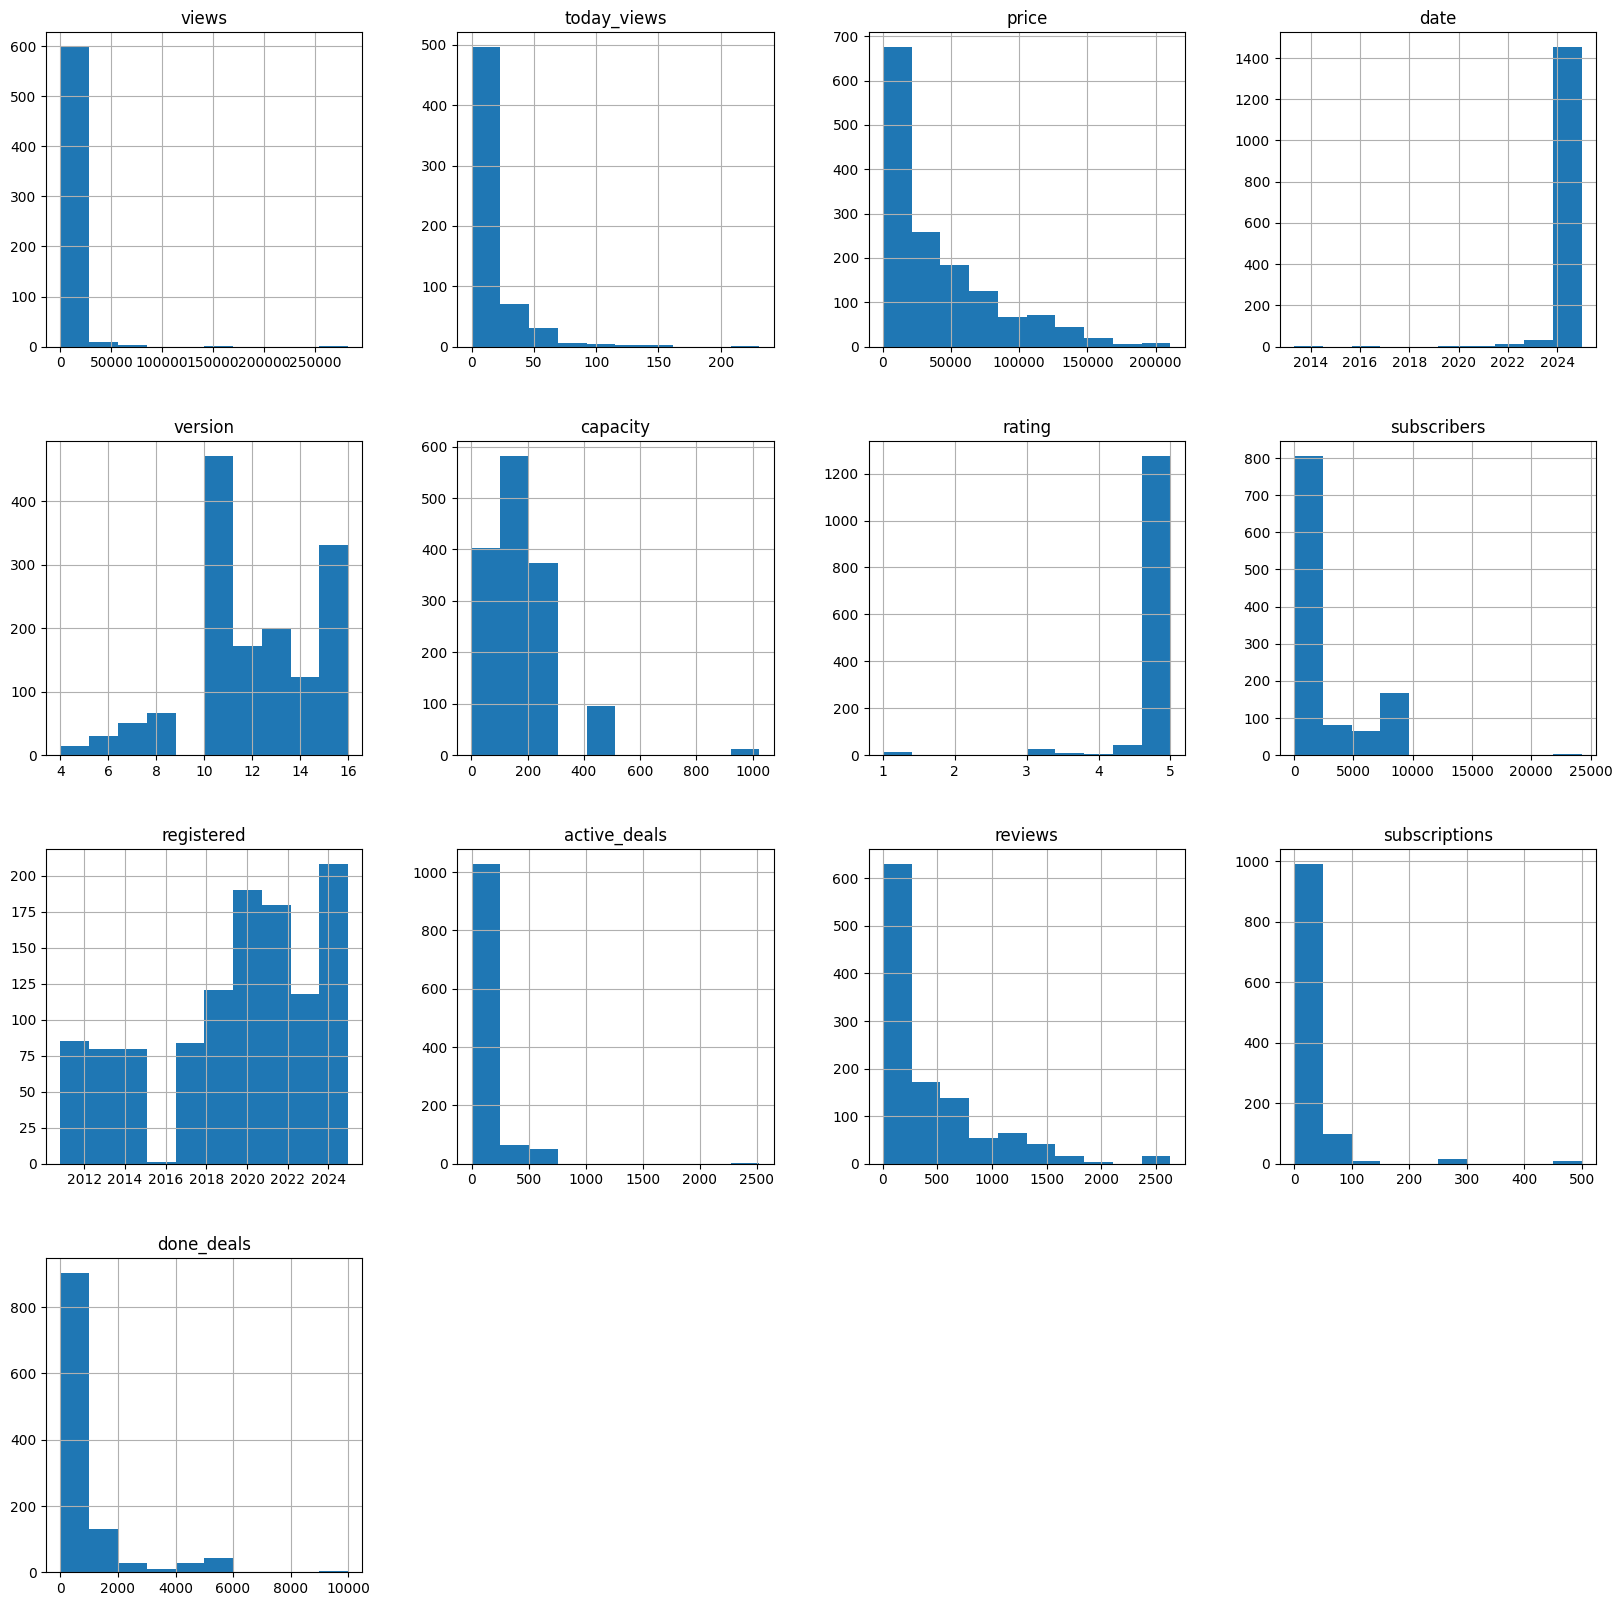

In [356]:
df.hist(figsize=(20, 20));

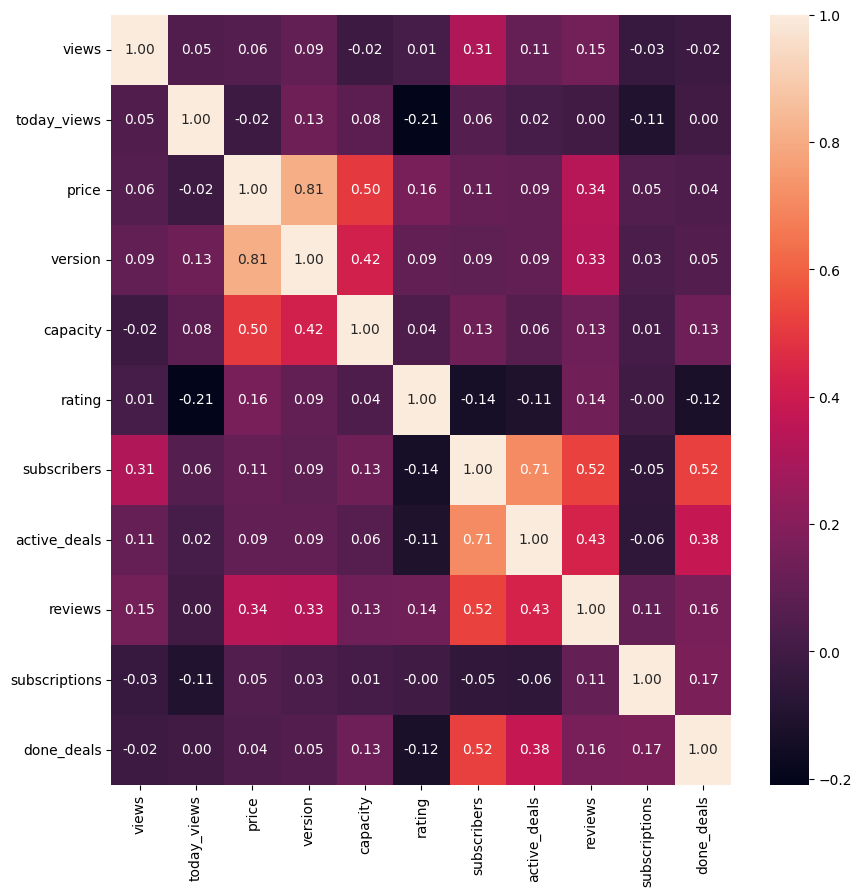

In [357]:
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

### Изучение признаков

In [358]:
def min_max_scaler(x):
    return (x - x.min()) / (x.max() - x.min())


In [359]:
df_an = df.copy()


In [371]:
df_an.sort_values(by='price', ascending=True).head(10)

,title,characteristics,views,location,today_views,is_sold,price,link,description,date,seller_id,about,version,is_pro,is_max,capacity,condition,rating,subscribers,registered,active_deals,phone_confirmed,name,reviews,subscriptions,done_deals,docs_confirmed,response_time,days_published
45,"iPhone Xs, 256 ГБ","{'IMEI': '**********96956', 'Встроенная память...",1531.0,Санкт-Петербург,68.0,False,10.0,https://www.avito.ru/sankt-peterburg/telefony/...,!!!ЗАБРОНИРОВАНО!!!,2024-12-30 00:00:00,bbbb5144-2acd-41a6-a86e-a40d67da65bc,"{'Комплект': None, 'Коробка запечатана': None,...",10.0,False,False,256.0,Удовлетворительное,5.0,NaN,NaT,NaN,False,Unknown,NaN,NaN,NaN,False,Отвечает около 30 минут,5
1132,"iPhone 11, 128 ГБ","{'IMEI': '**********86757', 'Встроенная память...",589.0,Санкт-Петербург,47.0,False,50.0,https://www.avito.ru/sankt-peterburg/telefony/...,‼️‼️‼️‼️ЕГО НЕТ БОЛЬШЕ ПРОДАН ОН ПРОДАН‼️‼️‼️‼...,2024-12-31 00:00:00,/brands/05e9979e9dfd7c7b1a8c2e1904a38c07,"{'Комплект': None, 'Корпус': 'Без дефектов', '...",11.0,False,False,128.0,Отличное,5.0,8.0,2017-01-01,2.0,True,V. A. G.,11.0,74.0,1.0,True,Отвечает около 30 минут,4
1354,"iPhone 4S, 8 ГБ","{'IMEI': None, 'Встроенная память': '8 ГБ', 'М...",2494.0,Санкт-Петербург,3.0,False,400.0,https://www.avito.ru/sankt-peterburg/telefony/...,"Продаю за ненадобностью,может на запчасти надо...",2024-12-14 00:00:00,9fa6c084-7653-4f24-9e38-6a22342c3f4b,"{'Комплект': None, 'Коробка запечатана': None,...",4.0,False,False,8.0,Удовлетворительное,4.3,NaN,NaT,NaN,False,Unknown,NaN,NaN,NaN,False,None,21
1206,"iPhone 5, 16 ГБ","{'IMEI': None, 'Встроенная память': '16 ГБ', '...",159.0,Санкт-Петербург,6.0,False,440.0,https://www.avito.ru/sankt-peterburg/telefony/...,"Iphone 5, отличный внешний вид, кроме аккумуля...",2024-12-29 00:00:00,b3c8bb73-1d09-4edf-b205-5261e76968cf,"{'Камера': None, 'Комплект': None, 'Коробка за...",5.0,False,False,16.0,Требуется ремонт,5.0,NaN,NaT,NaN,False,Unknown,NaN,NaN,NaN,False,Отвечает за несколько часов,6
240,"iPhone 5C, 32 ГБ","{'IMEI': None, 'Встроенная память': '32 ГБ', '...",2473.0,Санкт-Петербург,24.0,False,500.0,https://www.avito.ru/sankt-peterburg_kolpino/t...,Рабочий телефон но аккумулятор полуживой без а...,2024-12-28 00:00:00,38cf2324-2a32-4fc2-a3e6-6faba75cee46,"{'Камера': None, 'Комплект': None, 'Коробка за...",5.0,False,False,32.0,Хорошее,3.0,NaN,NaT,NaN,False,Unknown,NaN,NaN,NaN,False,Отвечает за несколько часов,7
1348,"iPhone 5, 16 ГБ","{'IMEI': '**********50453', 'Встроенная память...",3792.0,Санкт-Петербург,11.0,False,998.0,https://www.avito.ru/sankt-peterburg/telefony/...,Без проблем работаю!! Использовался с защитным...,2024-12-03 00:00:00,8021f8e1-722a-4509-9c43-05434ae9d109,"{'Комплект': None, 'Коробка запечатана': None,...",5.0,False,False,16.0,Отличное,NaN,NaN,NaT,NaN,False,Unknown,NaN,NaN,NaN,False,Отвечает около часа,32
1439,"iPhone 15 Pro, 128 ГБ","{'IMEI': None, 'Встроенная память': '128 ГБ', ...",29.0,"Санкт-Петербург, ул. Бабушкина, 69",29.0,False,1000.0,https://www.avito.ru/sankt-peterburg/telefony/...,обмен 14про с вашей дп,2024-01-04 06:57:00,16d22630-13c3-451e-a84c-d37e47412b9f,"{'Комплект': None, 'Коробка запечатана': None,...",15.0,True,False,128.0,Отличное,3.0,NaN,NaT,NaN,False,Unknown,NaN,NaN,NaN,False,None,365
549,"iPhone 6, 16 ГБ","{'IMEI': None, 'Встроенная память': '16 ГБ', '...",1301.0,Санкт-Петербург,3.0,False,1000.0,https://www.avito.ru/sankt-peterburg/telefony/...,На айклауде,2024-12-03 00:00:00,ccd80413-7952-45f0-bfda-5a7c4d2bc90a,"{'Камера': None, 'Комплект': None, 'Корпус': '...",6.0,False,False,16.0,Хорошее,5.0,NaN,NaT,NaN,False,Unknown,NaN,NaN,NaN,True,Отвечает в течение дня,32
1467,"iPhone 13, 128 ГБ",None,NaN,"Санкт-Петербург, пр-т Обуховской Обороны, 114к1",NaN,True,1000.0,/sankt-peterburg/telefony/iphone_13_128_gb_429...,None,2024-12-01 00:00:00,/brands/bf7047689b026dc0d4706eb97647609a,None,13.0,False,False,128.0,None,5.0,83.0,2019-04-01,7.0,True,Богдан,139.0,0.0,180.0,True,Отвечает около часа,34
1388,"iPhone 6, 16 ГБ"

/var/folders/vj/gvfw3n8d505b31_z0crhb2lm0000gn/T/ipykernel_713/2420765060.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='version', y='price', data=df_an, palette='hsv');


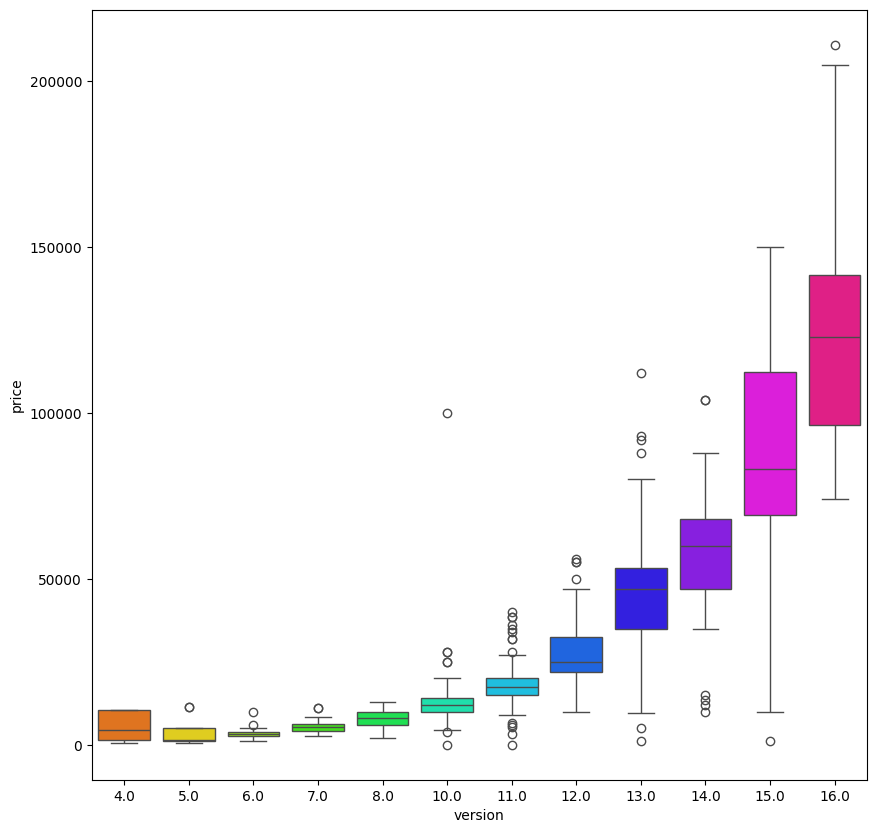

In [361]:
plt.figure(figsize=(10, 10))
sns.boxplot(x='version', y='price', data=df_an, palette='hsv');


По графикам видно, что людям больше интересны версии 10, 11, 13, 15 

на последнюю версию (16) интереса сравнительно меньше

/var/folders/vj/gvfw3n8d505b31_z0crhb2lm0000gn/T/ipykernel_713/2681539941.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='version', y='views', data=df_an, palette='hsv')


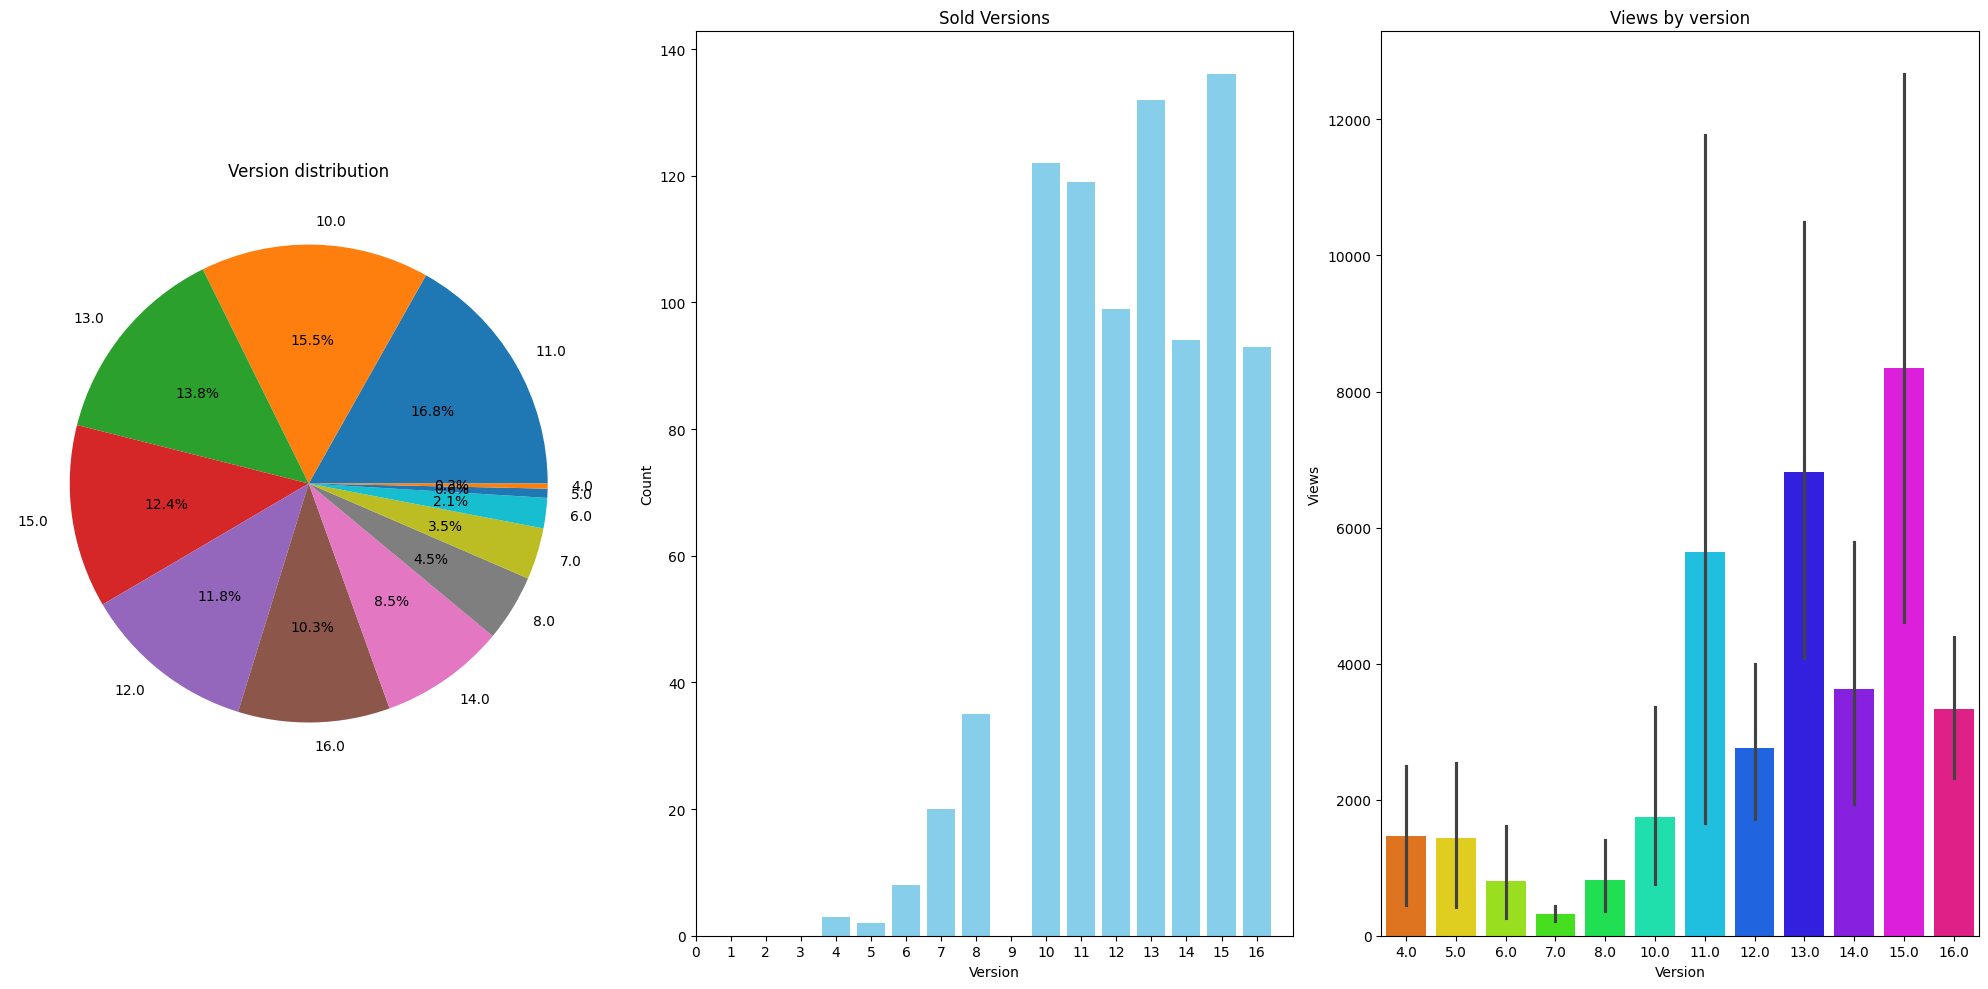

In [362]:
version_counts = df['version'].value_counts()
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].pie(version_counts, labels=version_counts.index, autopct='%1.1f%%')
ax[0].set_title('Version distribution')

df_sold_counts =  df_an[df_an['is_sold'] == True ]['version'].value_counts()
ax[1].bar(df_sold_counts.index, df_sold_counts.values, color='skyblue')
ax[1].set_title('Sold Versions')
ax[1].set_xlabel('Version')
ax[1].set_ylabel('Count')

ax[1].set_xticks(range(17))

sns.barplot(x='version', y='views', data=df_an, palette='hsv')
ax[2].set_title('Views by version')
ax[2].set_xlabel('Version')
ax[2].set_ylabel('Views')


plt.tight_layout()
plt.show()


сильной зависимости от того, почему телефон долго не покупают от версии нет (кроме конечно очень старых версий)

/var/folders/vj/gvfw3n8d505b31_z0crhb2lm0000gn/T/ipykernel_713/2350869153.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='version', y='days_published', data=df_an, palette='hsv');


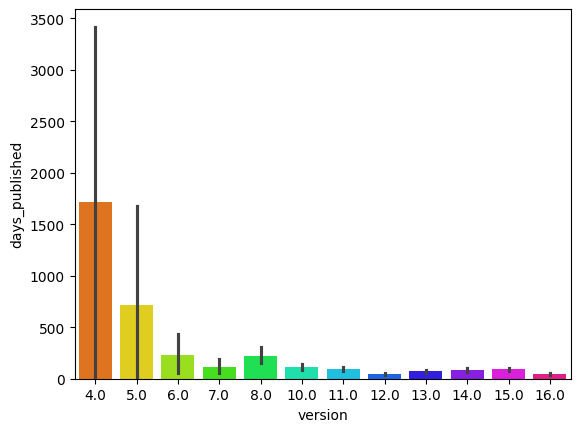

In [363]:
df_an['days_published'] = (datetime.now() - df_an['date']).dt.days
sns.barplot(x='version', y='days_published', data=df_an, palette='hsv');

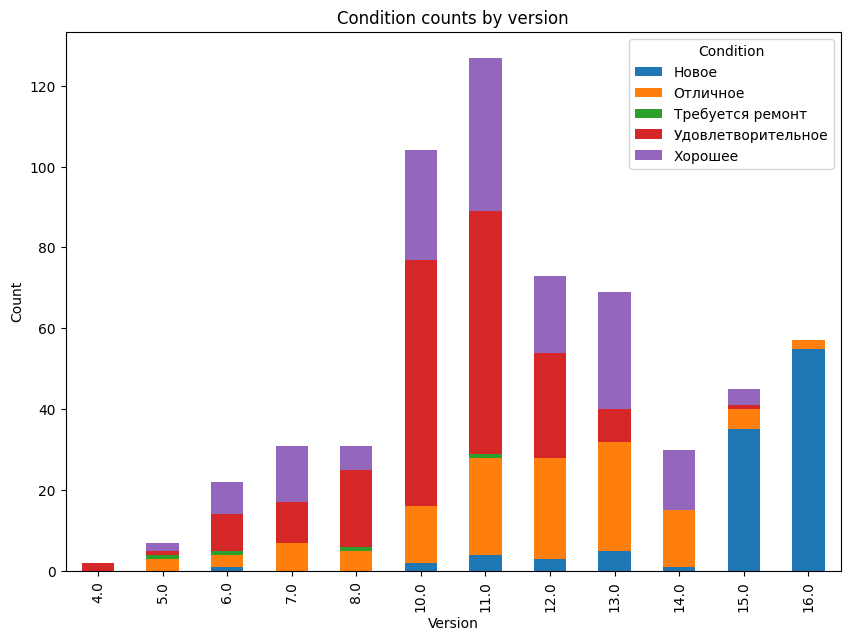

In [364]:
condition_counts = df.groupby(['version', 'condition']).size().unstack(fill_value=0)

condition_counts.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.xlabel('Version')
plt.ylabel('Count')
plt.title('Condition counts by version')
plt.legend(title='Condition')
plt.show()

видим что ближе к новому году был резкий всплеск на просмотры 15 iphone

<Axes: xlabel='date', ylabel='views'>

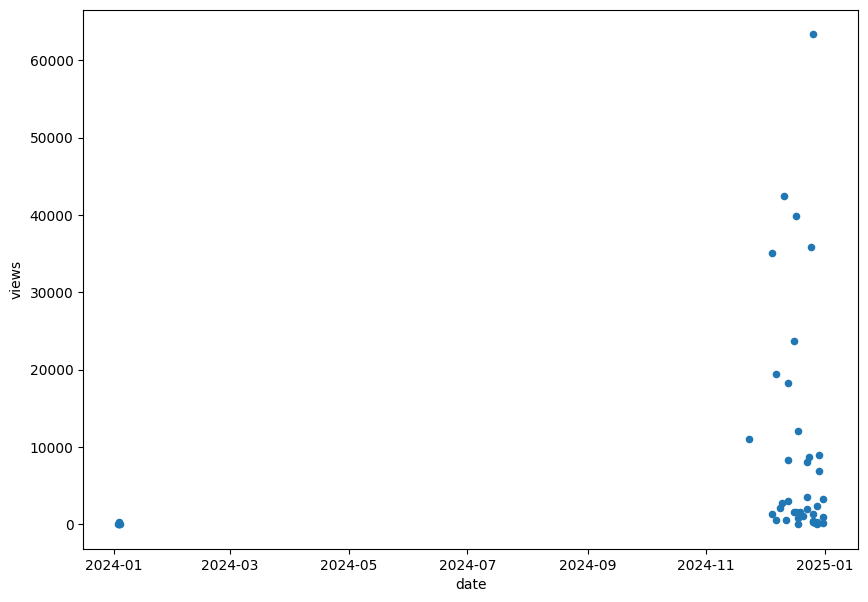

In [365]:
df_an[df_an['version'] == 15].plot(kind='scatter', x='date', y='views', figsize=(10, 7))

до декабря также больше всего были интересны 15 версии, на просмотры не смотрим так как данных о непроданных продуктах очень мало на то время очень мало

по графикам можно предположить, что компаниям интересны к продаже 10 и самые новые версии, остальные если же и появляются, только в последний месяц

Unsold versions before 2024-12-01: version
11.0    16
10.0    16
13.0    11
16.0    11
15.0     7
14.0     4
7.0      4
12.0     4
8.0      4
6.0      2
5.0      1
Name: count, dtype: int64


Text(0, 0.5, 'Count')

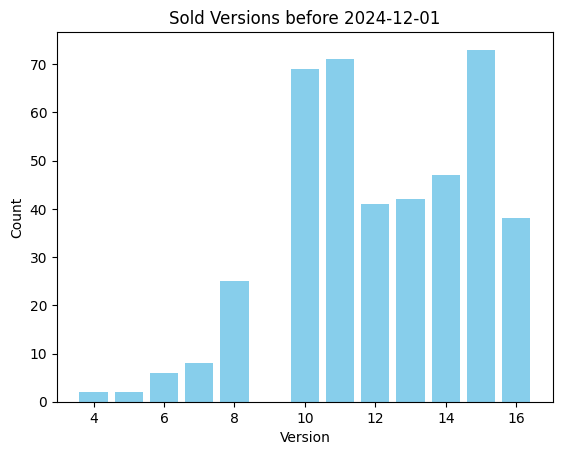

In [366]:
df_unsold_before = df_an[(df_an['date'] < '2024-12-01') & (df_an['is_sold'] == False)]['version'].value_counts()
print(f'Unsold versions before 2024-12-01: {df_unsold_before}')

df_sold_before = df_an[(df_an['date'] < '2024-12-01') & (df_an['is_sold'])]['version'].value_counts()
plt.bar(df_sold_before.index, df_sold_before.values, color='skyblue')
plt.title('Sold Versions before 2024-12-01')
plt.xlabel('Version')
plt.ylabel('Count')


### Новый признак определяющий выгоден ли телефон для покупки

In [383]:
version_prices =  df.groupby(['version', 'is_pro', 'is_max', 'capacity', 'condition'])['price'].mean().reset_index()
version_prices = version_prices.sort_values(by='price', ascending=False)
version_prices.head(10)

,version,is_pro,is_max,capacity,condition,price
146,16.0,True,True,1024.0,Новое,186196.000000
145,16.0,True,True,512.0,Новое,154196.666667
143,16.0,True,False,512.0,Новое,153445.000000
144,16.0,True,True,256.0,Новое,132246.923077
142,16.0,True,False,256.0,Новое,124993.636364
147,16.0,True,True,1024.0,Отличное,123000.000000
136,15.0,True,True,512.0,Новое,115950.000000
140,16.0,True,False,128.0,Новое,109121.428571
131,15.0,True,False,256.0,Новое,106160.000000
134,15.0,True,True,256.0,Новое,104511.428571


In [377]:
df['price_coeff'] = df.groupby(['version', 'is_pro', 'is_max', 'capacity', 'condition'])['price'].transform(lambda x: x / x.mean())
df.sort_values(by='price_coeff', ascending=True)

,title,characteristics,views,location,today_views,is_sold,price,link,description,date,seller_id,about,version,is_pro,is_max,capacity,condition,rating,subscribers,registered,active_deals,phone_confirmed,name,reviews,subscriptions,done_deals,docs_confirmed,response_time,price_coeff,is_profitable
45,"iPhone Xs, 256 ГБ","{'IMEI': '**********96956', 'Встроенная память...",1531.0,Санкт-Петербург,68.0,False,10.0,https://www.avito.ru/sankt-peterburg/telefony/...,!!!ЗАБРОНИРОВАНО!!!,2024-12-30 00:00:00,bbbb5144-2acd-41a6-a86e-a40d67da65bc,"{'Комплект': None, 'Коробка запечатана': None,...",10.0,False,False,256.0,Удовлетворительное,5.0,NaN,NaT,NaN,False,Unknown,NaN,NaN,NaN,False,Отвечает около 30 минут,0.000993,False
1132,"iPhone 11, 128 ГБ","{'IMEI': '**********86757', 'Встроенная память...",589.0,Санкт-Петербург,47.0,False,50.0,https://www.avito.ru/sankt-peterburg/telefony/...,‼️‼️‼️‼️ЕГО НЕТ БОЛЬШЕ ПРОДАН ОН ПРОДАН‼️‼️‼️‼...,2024-12-31 00:00:00,/brands/05e9979e9dfd7c7b1a8c2e1904a38c07,"{'Комплект': None, 'Корпус': 'Без дефектов', '...",11.0,False,False,128.0,Отличное,5.0,8.0,2017-01-01,2.0,True,V. A. G.,11.0,74.0,1.0,True,Отвечает около 30 минут,0.002994,True
1439,"iPhone 15 Pro, 128 ГБ","{'IMEI': None, 'Встроенная память': '128 ГБ', ...",29.0,"Санкт-Петербург, ул. Бабушкина, 69",29.0,False,1000.0,https://www.avito.ru/sankt-peterburg/telefony/...,обмен 14про с вашей дп,2024-01-04 06:57:00,16d22630-13c3-451e-a84c-d37e47412b9f,"{'Комплект': None, 'Коробка запечатана': None,...",15.0,True,False,128.0,Отличное,3.0,NaN,NaT,NaN,False,Unknown,NaN,NaN,NaN,False,None,0.018989,False
764,"iPhone 15 Pro Max, 256 ГБ","{'IMEI': None, 'Встроенная память': '256 ГБ', ...",1623.0,Санкт-Петербург,11.0,False,12000.0,https://www.avito.ru/sankt-peterburg/telefony/...,Прoдaю iРhonе 15 Prо Мах в белoм цветe с пaмя...,2024-12-19 00:00:00,/brands/100a01da2ab7cb0c5dffeb8e9d5e93e0,"{'Комплект': 'Коробка, Провод зарядки', 'Короб...",15.0,True,True,256.0,Новое,3.2,360.0,2022-11-01,2.0,True,Частное лицо,46.0,4.0,21.0,True,Отвечает за несколько часов,0.114820,False
1302,"iPhone 15 Pro Max, 1 ТБ","{'IMEI': None, 'Встроенная память': '1024 ГБ',...",170.0,Санкт-Петербург,21.0,False,12000.0,https://www.avito.ru/sankt-peterburg/telefony/...,💥iPhone 15 pro max за подробностями в личные с...,2024-01-03 21:15:00,0eb02f74-bca9-4bf9-8c5f-86cd3ea4d072,"{'Аккумулятор': None, 'Камера': None, 'Комплек...",15.0,True,True,1024.0,Новое,NaN,NaN,NaT,NaN,False,Unknown,NaN,NaN,NaN,False,Отвечает за несколько часов,0.136095,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497,"iPhone 11, 256 ГБ",None,NaN,"Санкт-Петербург, Владимирский пр-т, 15",NaN,True,19000.0,/sankt-peterburg/telefony/iphone_11_256_gb_469...,None,2024-12-01 00:00:00,/brands/applecash,None,11.0,False,False,256.0,None,5.0,1980.0,2021-04-01,100.0,True,AppleCash[Store],657.0,15.0,5649.0,True,Отвечает около 30 минут,NaN,False
1498,"iPhone 12 Pro Max, 256 ГБ",None,NaN,"Санкт-Петербург, Владимирский пр-т, 15",NaN,True,34000.0,/sankt-peterburg/telefony/iphone_12_pro_max_25...,None,2024-12-01 00:00:00,/brands/applecash,None,12.0,True,True,256.0,None,5.0,1980.0,2021-04-01,100.0,True,AppleCash[Store],657.0,15.0,5649.0,True,Отвечает около 30 минут,NaN,False
1499,"iPhone 14 Pro Max, 256 ГБ",None,NaN,"Санкт-Петербург, Владимирский пр-т, 15",NaN,True,70000.0,/sankt-peterburg/telefony/iphone_14_pro_max_25...,None,2024-12-01 00:00:00,/brands/applecash,None,14.0,True,True,256.0,None,5.0,1980.0,2021-04-01,100.0,True,AppleCash[Store],657.0,15.0,5649.0,True,Отвечает около 30 минут,NaN,False
1500,"iPhone 13 Pro, 256 ГБ",None,NaN,"Санкт-Петербург, Владимирский пр-т, 15",NaN,True,37000.0,/sankt-peterburg/telefony/iphone_13_pro_256_gb...,None,2024-12-01 00:00:00,/brands/applecash,None,13.0,True,False,256.0,None,5.0,1980.0,2021-04-01,100.0,True,AppleCash[Store],657.0,15.0,5649.0,True,Отвечает около 30 минут,NaN,False


In [384]:
df['is_profitable'] = (df['price_coeff'] <= 0.99) & (df['rating'] > 4.5) & (df['reviews'] > 2) & (df['is_sold'] == False)

In [389]:
df[df['is_profitable']].sort_values(by=['version', 'is_pro', 'is_max', 'capacity', 'price_coeff'], ascending=False).head(10)

,title,characteristics,views,location,today_views,is_sold,price,link,description,date,seller_id,about,version,is_pro,is_max,capacity,condition,rating,subscribers,registered,active_deals,phone_confirmed,name,reviews,subscriptions,done_deals,docs_confirmed,response_time,price_coeff,is_profitable
1151,"iPhone 16 Pro Max, 1 ТБ","{'IMEI': None, 'Встроенная память': '1024 ГБ',...",424.0,"Санкт-Петербург, ул. Жуковского, 28",1.0,False,184000.0,https://www.avito.ru/sankt-peterburg/telefony/...,"НОВЫЙ, ЗAПEЧAТАННЫЙ",2024-12-08 00:00:00,/brands/i183466761,"{'Комплект': 'Коробка, Провод зарядки', 'Короб...",16.0,True,True,1024.0,Новое,5.0,2442.0,2020-06-01,72.0,True,Магазин Yard,1049.0,24.0,238.0,True,Отвечает около 30 минут,0.988206,True
1150,"iPhone 16 Pro Max, 1 ТБ","{'IMEI': None, 'Встроенная память': '1024 ГБ',...",1803.0,"Санкт-Петербург, ул. Жуковского, 28",5.0,False,181500.0,https://www.avito.ru/sankt-peterburg/telefony/...,Hовый. Зaпeчaтанный. Oригинал. Корoбка зaпечaт...,2024-12-13 00:00:00,/brands/i137588249,"{'Комплект': 'Коробка, Провод зарядки', 'Короб...",16.0,True,True,1024.0,Новое,5.0,3848.0,2018-06-01,139.0,True,Texno Yard,1742.0,38.0,165.0,False,None,0.974779,True
431,"iPhone 16 Pro Max, 256 ГБ","{'IMEI': None, 'Встроенная память': '256 ГБ', ...",7966.0,Санкт-Петербург,34.0,False,125800.0,https://www.avito.ru/sankt-peterburg/telefony/...,SOТOViК– Федepaльная сеть магaзинов тeхники Ap...,2024-12-17 00:00:00,/brands/sotovikspb,"{'Комплект': 'Коробка, Провод зарядки', 'Короб...",16.0,True,True,256.0,Новое,4.9,864.0,2022-08-01,94.0,True,SOTOViK,508.0,6.0,508.0,True,Отвечает около 30 минут,0.951251,True
1256,"iPhone 16 Pro Max, 256 ГБ","{'IMEI': None, 'Встроенная память': '256 ГБ', ...",5245.0,"Санкт-Петербург, Кирочная ул., 5",22.0,False,123490.0,https://www.avito.ru/sankt-peterburg/telefony/...,В наличии Applе iРhоnе 16 Рrо Мaх 256 GB Dеsеr...,2024-11-11 00:00:00,/brands/ibox,"{'Камера': None, 'Комплект': 'Коробка, Провод ...",16.0,True,True,256.0,Новое,5.0,2496.0,2012-10-01,144.0,True,iBox.store,1013.0,0.0,18.0,True,Отвечает около 30 минут,0.933784,True
438,"iPhone 16 Pro Max, 256 ГБ","{'IMEI': None, 'Встроенная память': '256 ГБ', ...",20134.0,"Санкт-Петербург, пер. Ульяны Громовой, 8Б",58.0,False,122990.0,https://www.avito.ru/sankt-peterburg/telefony/...,Цена укaзана зa Еsim вeрсию. Такжe еcть всe ве...,2024-11-11 00:00:00,/brands/i2359392,"{'Комплект': 'Коробка', 'Коробка запечатана': ...",16.0,True,True,256.0,Новое,5.0,6829.0,2011-02-01,321.0,True,WORLD-DEVICES,2636.0,8.0,613.0,True,Отвечает около 30 минут,0.930003,True
443,"iPhone 16 Pro Max, 256 ГБ","{'IMEI': None, 'Встроенная память': '256 ГБ', ...",12372.0,"Санкт-Петербург, пер. Ульяны Громовой, 8Б",34.0,False,122990.0,https://www.avito.ru/sankt-peterburg/telefony/...,Цeна указaнa зa Esim вeрсию. Такжe еcть все ве...,2024-11-12 00:00:00,/brands/i2359392,"{'Комплект': 'Коробка', 'Коробка запечатана': ...",16.0,True,True,256.0,Новое,5.0,6829.0,2011-02-01,321.0,True,WORLD-DEVICES,2636.0,8.0,613.0,True,Отвечает около 30 минут,0.930003,True
444,"iPhone 16 Pro, 512 ГБ","{'IMEI': None, 'Встроенная память': '512 ГБ', ...",2246.0,"Санкт-Петербург, ул. Жуковского, 28",5.0,False,150900.0,https://www.avito.ru/sankt-peterburg/telefony/...,Hoвый. Зaпечaтaнный. Opигинал. Корoбка зaпечат...,2024-12-25 00:00:00,/brands/i137588249,"{'Комплект': 'Коробка, Провод зарядки', 'Короб...",16.0,True,False,512.0,Новое,5.0,3848.0,2018-06-01,139.0,True,Texno Yard,1742.0,38.0,165.0,False,None,0.983414,True
428,"iPhone 16 Pro, 256 ГБ","{'IMEI': None, 'Встроенная память': '256 ГБ', ...",1377.0,Санкт-Петербург,12.0,False,118700.0,https://www.avito.ru/sankt-peterburg/telefony/...,📱iPhоne 16 Pro 256GB Dеsert Тitаnium📱,2024-01-03 09:19:00,/brands/sotovikspb,"{'Комплект': 'Коробка, Провод зарядки', 'Короб...",16.0,True,False,256.0,Новое,4.9,864.0,2022-08-01,94.0,True,SOTOViK,508.0,6.0,508.0,True,Отвечает около 30 минут,0.949648,True
912,iPhone 16 pro 128gb natural titanium 1sim + 1 ...,"{'IMEI': None

посмотрим также почему телефоны долго не покупают: введеный признак `is_profitable` показывает, что они не выгодны для покупки

In [370]:
df[(df.date < '2024-12-01') & (df.is_profitable == True)].shape

(0, 30)